<a href="https://colab.research.google.com/github/mkarimi53/OS/blob/master/Copy_of_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="ltr">
  <h1 align="leftr">  CNN </h1>
  <p>  Reza Farzi </br>
          810193462
  </p>
  </div>

<div style="ltr">
  <h2 align="left"> Imports </h2>
  </div>

In [0]:
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.autograd import Variable
import numpy as np
from google.colab import files
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import time

<div style="ltr">
  <h2 align="left"> Defines </h2>
  </div>

In [0]:
CLASSES_NAME = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

<div style="ltr">
  <h2 align="left"> Util Functions </h2>
  </div>

In [0]:
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

def show_batch_images(data_loader):
  dataiter = iter(data_loader)
  images, labels = dataiter.next()

  fig, axes = plt.subplots(1, len(images), figsize=(48,10))
  for idx, image in enumerate(images):
      axes[idx].imshow(convert_to_imshow_format(image))
      axes[idx].set_title(CLASSES_NAME[labels[idx]])
      axes[idx].set_xticks([])
      axes[idx].set_yticks([])
      
def show_result(test_num):
  uploaded = files.upload()
  
  print("result for test"+str(test_num)+" :")
  
  im1 = Image.open(BytesIO(uploaded['test'+str(test_num)+'_1.png']))
  plt.subplots(1, figsize=(10,10))
  plt.imshow(im1)
  plt.show()

  im2 = Image.open(BytesIO(uploaded['test'+str(test_num)+'_2.png']))
  plt.subplots(1, figsize=(10,10))
  plt.imshow(im2)
  plt.show()

<div style="ltr">
  <h2 align="left">  Load data function</h2>
  </div>

In [0]:
def load_data(folder_name, train, transforms_func, batch_size, show):
  data_set = CIFAR10(root=folder_name,train=train,transform=transforms_func,download=True)   
  data_loader = DataLoader(data_set,batch_size=batch_size,shuffle=True,num_workers=4)
  
  if show == "ON" :
    show_batch_images(data_loader)
    
  return data_loader

<div style="ltr">
  <h2 align="left">  Defining the Convolutional Neural Network Block </h2>
 </div>

In [0]:
class ConvLayer(nn.Module):
  def __init__(self,in_channels,out_channels, init_func = "None" , active_func = "ReLU"):
      super(ConvLayer,self).__init__()

      self.conv = nn.Conv2d(in_channels=in_channels,kernel_size=3,out_channels=out_channels,stride=1,padding=1)
      
      #init weights and biases
      if init_func != "None":
        self.conv.apply(init_func)
      
      #set activation function
      if active_func == "ReLU":
        self.activation_func = nn.ReLU()
      elif active_func == "Tanh":
        self.activation_func = nn.Tanh()
      elif active_func == "LeakyReLU":
        self.activation_func = nn.LeakyReLU()
      elif active_func == "Softplus":
        self.activation_func = nn.Softplus()

  def forward(self,input):
      output = self.conv(input)
      output = self.activation_func(output)

      return output

<div style="ltr">
  <h2 align="left">  Set weight and bias functions </h2>
 </div>

In [0]:
def weights_init_normal(m):
  nn.init.xavier_normal(m.weight)

def weights_init_uniform(m):
  nn.init.xavier_uniform(m.weight)
  
def weights_init_uniform_rule(m):
  n = m.in_features
  y = 1.0/np.sqrt(n)
  m.weight.data.uniform_(-y, y)
          
def weights_init_zero(m):
  m.weight.data.fill_(0)

# def weights_init_normal(m):
#   if type(m) == nn.ReLU:
#     return
#   # get the number of the inputs
#   y = m.in_features
#   # m.weight.data shoud be taken from a normal distribution
#   m.weight.data.normal_(0.0,1/np.sqrt(y))
#   # m.bias.data should be 0
#   m.bias.data.fill_(0)

<div style="ltr">
  <h2 align="left">  Save and Test Functions </h2>
 </div>

In [0]:
def save_models(model, epoch, result_folder_addr):
    torch.save(model.state_dict(), result_folder_addr+"/cifar10model_{}.model".format(epoch))
    print("Checkpoint saved")

def test(model, test_loader, cuda_avail):
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):
      
        if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

        outputs = model(images)
        _,prediction = torch.max(outputs.data, 1)
        
        for i in range(prediction.size(0)):
              if(prediction[i] == labels.data[i]):
                test_acc += 1
                
#         test_acc += torch.sum(prediction == labels.data)
        
    test_acc = test_acc / 10000

    return test_acc

<div style="ltr">
  <h2 align="left">  Train Function </h2>
 </div>

In [0]:
def train(model, optimizer, loss_fn, num_epochs, train_loader, test_loader, cuda_avail, result_folder_addr):
  best_acc = 0.0
  train_acc = 0.0
  loss_list = []
    
  for epoch in range(num_epochs):
      model.train()
      train_acc = 0.0
      train_loss = 0.0
      for i, (images, labels) in enumerate(train_loader):
          #Move images and labels to gpu if available
          if cuda_avail:
              images = Variable(images.cuda())
              labels = Variable(labels.cuda())

          #Clear all accumulated gradients
          optimizer.zero_grad()
          #Predict classes using images from the test set
          outputs = model(images)
          #Compute the loss based on the predictions and actual labels
          loss = loss_fn(outputs,labels)
          loss_list.append(loss)
          #Backpropagate the loss
          loss.backward()

          #Adjust parameters according to the computed gradients
          optimizer.step()

          train_loss += loss.cpu().data.item() * images.size(0)
          _, prediction = torch.max(outputs.data, 1)

          for i in range(prediction.size(0)):
            if(prediction[i] == labels.data[i]):
              train_acc += 1

  #             train_acc += torch.sum(prediction == labels.data)

      #Compute the average acc and loss over all 50000 training images
      train_acc = train_acc / 50000
      train_loss = train_loss / 50000

      #Evaluate on the test set
      test_acc = test(model, test_loader, cuda_avail)

      # Save the model if the test acc is greater than our current best
      if test_acc > best_acc:
          save_models(model, epoch, result_folder_addr)
          best_acc = test_acc


      # Print the metrics
      print("Epoch {}, Train Accuracy: {} , Test Accuracy: {}".format(epoch, train_acc, test_acc))
        
  return train_acc, loss_list, test_acc     


<div style="ltr">
  <h2 align="left">  Train Model  :   </h2>
  </h3>
  -  get model, optimization function,  loss function, epoch, train and test loaders </br>
  -  set to run on GPU (if available) </br>
  -  train and show result </br>
 </h3>
 </div>

In [0]:
def train_model(model, optimizer, loss_fn, epoch, train_loader, test_loader, result_folder_addr):
  cuda_avail = torch.cuda.is_available()
  
  if cuda_avail:
    model.cuda()
  
  start = time.time()
  
  train_acc, train_loss, test_acc  = train(model, optimizer, loss_fn, epoch, train_loader, test_loader, cuda_avail, result_folder_addr)
  
  end = time.time()
  print("train model time : {} sec".format(end - start))
  
  return train_acc, train_loss, test_acc 

<div style="ltr">
  <h2 align="left">  Part 1 : play with hyper parameters  </h2>
 </div>

In [0]:
data_folder_addr = "./p1/data"
result_folder_addr = "./p1"
batch_size = 32
epoch = 5

class TestNet(nn.Module):
    def __init__(self,num_classes=10):
        super(TestNet,self).__init__()

        self.convLayer1 = ConvLayer(in_channels=3,out_channels=32, init_func = weights_init_normal , active_func = "ReLU")
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.convLayer2 = ConvLayer(in_channels=32,out_channels=128, init_func = weights_init_normal , active_func = "ReLU")
        
        self.net = nn.Sequential(self.convLayer1, self.pool1, self.convLayer2)

        self.fc = nn.Linear(in_features=16*16*128, out_features=num_classes)
        self.fc.apply(weights_init_normal)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,16*16*128)
        output = self.fc(output)
        return output

train_transformations = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(32,padding=4),
    transforms.ToTensor()])

train_loader = None
train_loader = load_data(data_folder_addr, True, train_transformations, batch_size, "OFF")

test_transformations = transforms.Compose([
   transforms.ToTensor()])

test_loader = None
test_loader = load_data(data_folder_addr, False, test_transformations, batch_size, "OFF")

model = None
model = TestNet(num_classes=10)

optimizer = None
optimizer = SGD(model.parameters(), lr=0.01, momentum = 0.9)
loss_fn = None
loss_fn = nn.CrossEntropyLoss()

train_acc = None
train_loss_list = None
test_acc = None
train_acc, train_loss_list, test_acc = train_model(model, optimizer, loss_fn, epoch, train_loader, test_loader, result_folder_addr)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  


Checkpoint saved
Epoch 0, Train Accuracy: 0.4624 , Test Accuracy: 0.5673
Checkpoint saved
Epoch 1, Train Accuracy: 0.60918 , Test Accuracy: 0.6368
Epoch 2, Train Accuracy: 0.67588 , Test Accuracy: 0.621
Checkpoint saved
Epoch 3, Train Accuracy: 0.7262 , Test Accuracy: 0.6526
Checkpoint saved
Epoch 4, Train Accuracy: 0.77154 , Test Accuracy: 0.6629
train model time : 113.52946090698242 sec


<div style="ltr">
  <h3 align="left">  change num of conv layers  </h3>
 </div>

Saving test1_1.png to test1_1.png
Saving test1_2.png to test1_2.png
result for test1 :


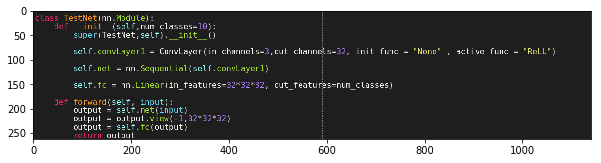

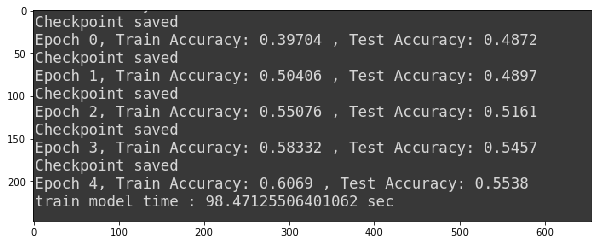

Saving test2_1.png to test2_1.png
Saving test2_2.png to test2_2.png
result for test2 :


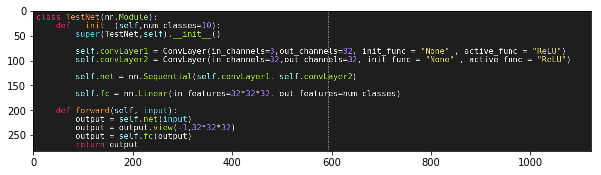

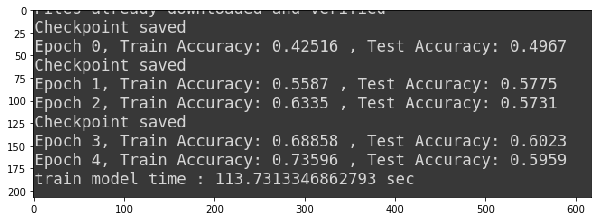

Saving test3_1.png to test3_1.png
Saving test3_2.png to test3_2.png
result for test3 :


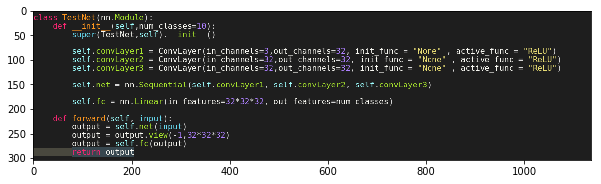

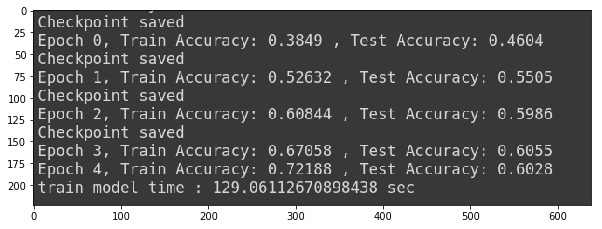

In [0]:
show_result(1)
show_result(2)
show_result(3)

<div style="ltr">
  <h3 align="left">  change num of filters </h3>
 </div>

Saving test4_1.png to test4_1.png
Saving test4_2.png to test4_2.png
result for test4 :


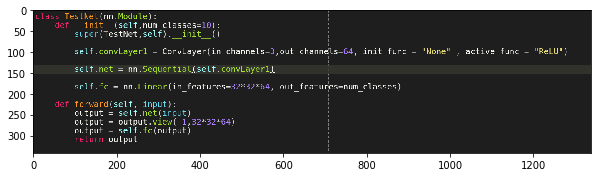

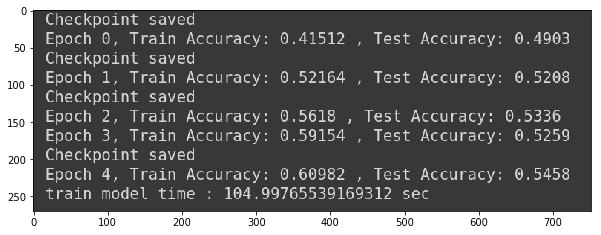

Saving test5_1.png to test5_1.png
Saving test5_2.png to test5_2.png
result for test5 :


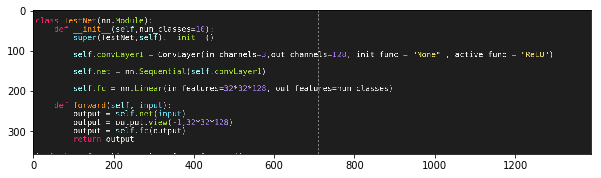

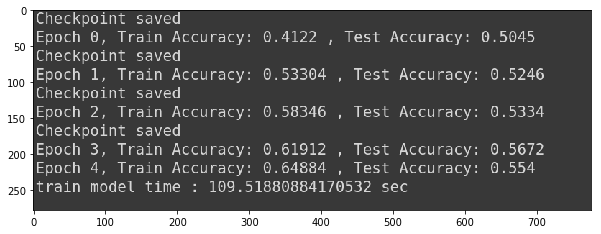

Saving test6_1.png to test6_1.png
Saving test6_2.png to test6_2.png
result for test6 :


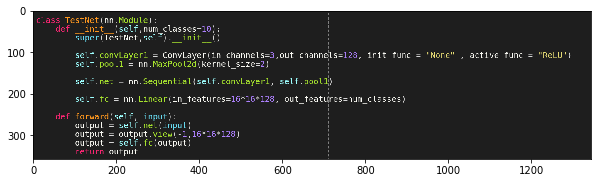

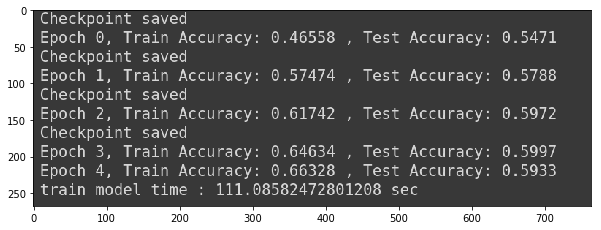

In [0]:
show_result(4)
show_result(5)
show_result(6)

<div style="ltr">
  <h3 align="left">  change both num of conv layers and filters  </h3>
 </div>

Saving test7_1.png to test7_1 (1).png
Saving test7_2.png to test7_2 (1).png
result for test7 :


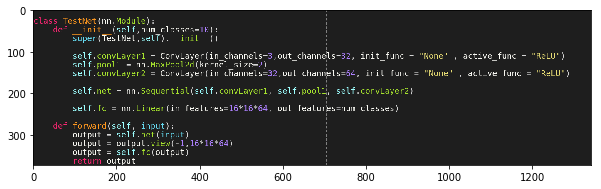

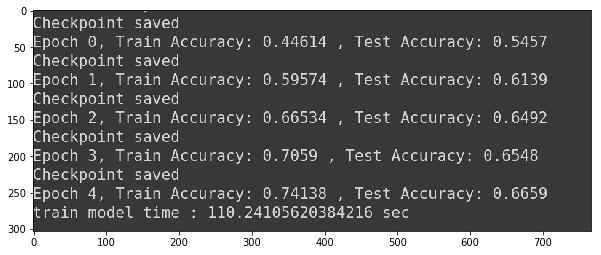

Saving test8_1.png to test8_1 (1).png
Saving test8_2.png to test8_2 (1).png
result for test8 :


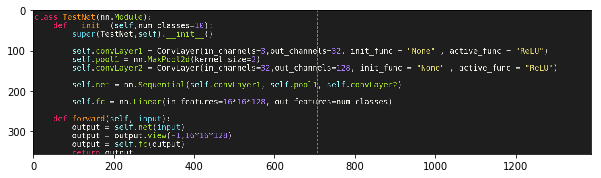

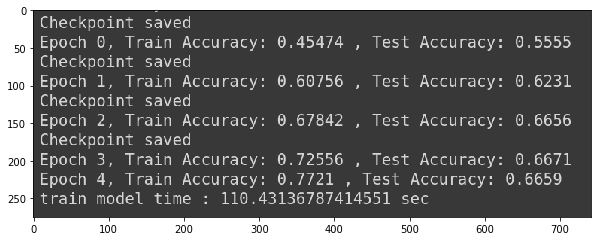

Saving test9_1.png to test9_1.png
Saving test9_2.png to test9_2.png
result for test9 :


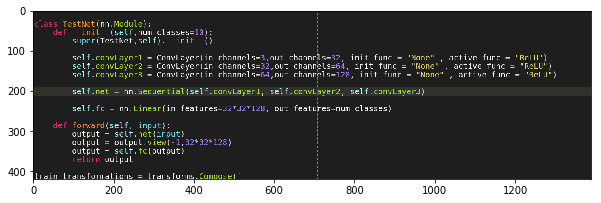

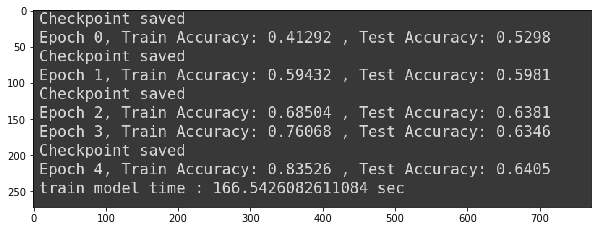

Saving test10_1.png to test10_1.png
Saving test10_2.png to test10_2.png
result for test10 :


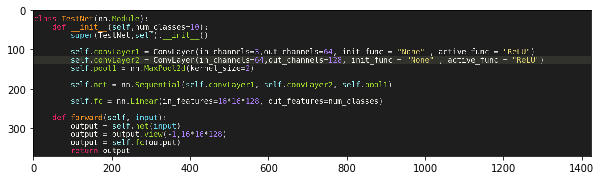

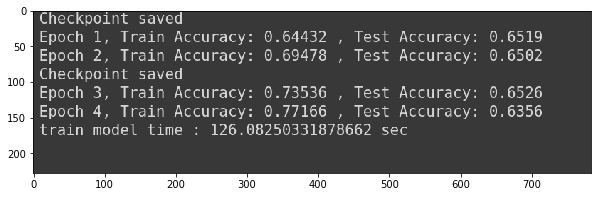

In [0]:
show_result(7)
show_result(8)
show_result(9)
show_result(10)

<div style="ltr">
  <h3 align="left">  set initial weights to zero  </h3>
 </div>

Saving test11_1.png to test11_1 (1).png
Saving test11_2.png to test11_2 (1).png
result for test11 :


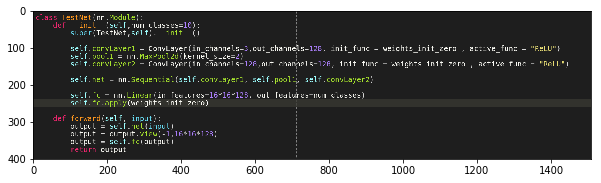

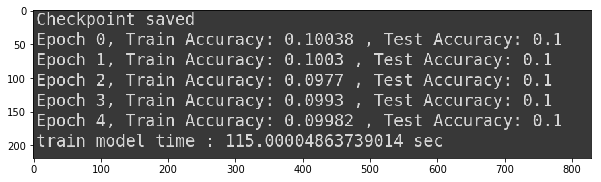

In [0]:
show_result(11)

<div style="ltr">
  <h3 align="left">  set initial weights with normal distribution  </h3>
 </div>

Saving test12_1.png to test12_1.png
Saving test12_2.png to test12_2.png
result for test12 :


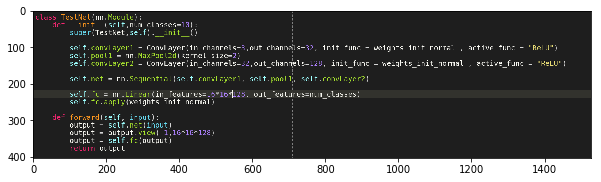

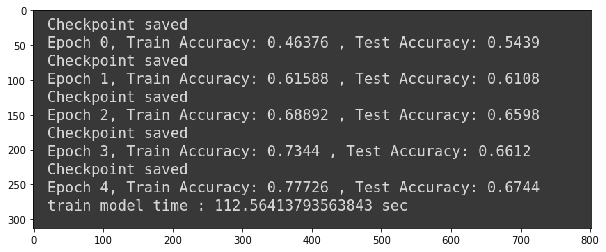

In [0]:
show_result(12)

<div style="ltr">
  <h3 align="left">  set initial weights with uniform distribution </h3>
 </div>

Saving test13_1.png to test13_1.png
Saving test13_2.png to test13_2.png
result for test13 :


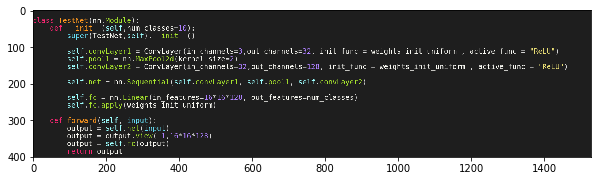

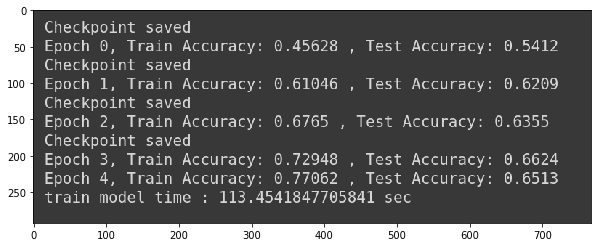

In [0]:
show_result(13)

<div style="ltr">
  <h3 align="left"> Part 1 conclusion : Test 1 to 6 => increasing in number of layers and number of neurons lead to increasing accuracy but increasing in number of layers has very greater slope.
Test 7 to 10 => if both of layers number and neurons number increase together in a good way we can reache a better result which be seen in Test8.
Test 11 to 13 => also random weights cause better results in compare to zero weights that cause very bad accuracy. finaly Test12 choose as the best model.</h3>
 </div>

<div style="ltr">
  <h2 align="left">  Part 2 : compare influence of neurons number on test and train accuracy   </h2>
 </h3>
 </div>

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
------------------------ num of neurons = 16 ----------------------------
Checkpoint saved
Epoch 0, Train Accuracy: 0.38442 , Test Accuracy: 0.4402
Checkpoint saved
Epoch 1, Train Accuracy: 0.48374 , Test Accuracy: 0.4774
Checkpoint saved
Epoch 2, Train Accuracy: 0.5277 , Test Accuracy: 0.5105
Epoch 3, Train Accuracy: 0.55356 , Test Accuracy: 0.5086
Epoch 4, Train Accuracy: 0.56642 , Test Accuracy: 0.5051
train model time : 99.610520362854 sec
------------------------ num of neurons = 32 ----------------------------
Checkpoint saved
Epoch 0, Train Accuracy: 0.42246 , Test Accuracy: 0.4798
Checkpoint saved
Epoch 1, Train Accuracy: 0.51312 , Test Accuracy: 0.4973
Checkpoint saved
Epoch 2, Train Accuracy: 0.54822 , Test Accuracy: 0.5174
Checkpoint saved
Epoch 3, Train Accuracy: 0.57834 , Test Accuracy: 0.5227
Checkpoint saved
Epoch 4, Train Accuracy: 0.60526 , Test Accuracy: 0

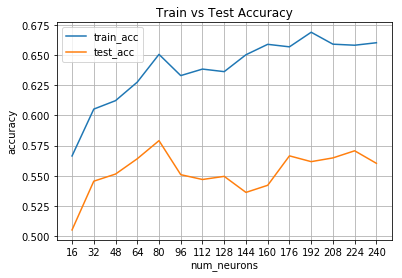

In [0]:
data_folder_addr = "./p2/data"
result_folder_addr = "./p2"
batch_size = 32
epoch = 5

test_loader = load_data(data_folder_addr, False, test_transformations, batch_size, "OFF")

class TestNet(nn.Module):
    def __init__(self, num_classes=10, num_neurons=32):
        super(TestNet,self).__init__()

        self.convLayer1 = ConvLayer(in_channels=3,out_channels=num_neurons)
        self.fc = nn.Linear(in_features=32*32*num_neurons,out_features=num_classes)

    def forward(self, input):
        output = self.convLayer1(input)
        output = output.view(-1,32*32*num_neurons)
        output = self.fc(output)
        return output



train_transformations = transforms.Compose([
    transforms.ToTensor()])

train_loader = None
train_loader = load_data(data_folder_addr, True, train_transformations, batch_size, "OFF")

test_transformations = transforms.Compose([
   transforms.ToTensor()])

test_loader = None
test_loader = load_data(data_folder_addr, False, test_transformations, batch_size, "OFF")

num_neurons_list = []     
train_acc_list = []
test_acc_list = []

for num_neurons in range(16, 256, 16):
  print("------------------------ num of neurons = {} ----------------------------".format(num_neurons))
  
  model = None
  model = TestNet(num_classes=10, num_neurons=num_neurons)
  
  optimizer = None
  optimizer = SGD(model.parameters(), lr=0.01, momentum = 0.9)
  loss_fn = None
  loss_fn = nn.CrossEntropyLoss()
  
  train_acc = None 
  train_loss_list = None
  test_acc = None
  train_acc, train_loss_list, test_acc  = train_model(model, optimizer, loss_fn, epoch, train_loader, test_loader, result_folder_addr)
  
  num_neurons_list.append(num_neurons)
  train_acc_list.append(train_acc)
  test_acc_list.append(test_acc)
  

plt.plot(num_neurons_list, train_acc_list, label = "train_acc") 
plt.plot(num_neurons_list, test_acc_list, label = "test_acc") 
  
plt.xlabel('num_neurons') 
plt.ylabel('accuracy')
plt.title('Train vs Test Accuracy') 

plt.xticks(np.arange(min(num_neurons_list), max(num_neurons_list)+1, 16))
  
plt.legend() 
plt.grid()

plt.show() 

<div style="ltr">
  <h3 align="left"> Part 2 conclusion :  increasing neurons number without increasing layers number is not very effective so in compare with multilayer network with the same number of neurons we obtain lower accuracy on test data. in the other hand </h3>
 </div>

<div style="ltr">
  <h2 align="left">  Part 3 : influence of data normalization on speed and accuracy of model  </h2>
 </h3>
 </div>

In [0]:
data_folder_addr = "./p3/data"
result_folder_addr = "./p3"
batch_size = 32
epoch = 5

class TestNet(nn.Module):
    def __init__(self,num_classes=10):
        super(TestNet,self).__init__()

        self.convLayer1 = ConvLayer(in_channels=3,out_channels=32, init_func = weights_init_normal , active_func = "ReLU")
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.convLayer2 = ConvLayer(in_channels=32,out_channels=128, init_func = weights_init_normal , active_func = "ReLU")
        
        self.net = nn.Sequential(self.convLayer1, self.pool1, self.convLayer2)

        self.fc = nn.Linear(in_features=16*16*128, out_features=num_classes)
        self.fc.apply(weights_init_normal)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,16*16*128)
        output = self.fc(output)
        return output

train_transformations = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = None
train_loader = load_data(data_folder_addr, True, train_transformations, batch_size, "OFF")

test_transformations = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

test_loader = None
test_loader = load_data(data_folder_addr, False, test_transformations, batch_size, "OFF")

model = None  
model = TestNet(num_classes=10)

optimizer = None
optimizer = SGD(model.parameters(), lr=0.01, momentum = 0.9)
loss_fn = None
loss_fn = nn.CrossEntropyLoss()

train_acc = None 
train_loss_list = None
test_acc = None
train_acc, train_loss_list, test_acc  = train_model(model, optimizer, loss_fn, epoch, train_loader, test_loader, result_folder_addr)


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  


Checkpoint saved
Epoch 0, Train Accuracy: 0.53064 , Test Accuracy: 0.6215
Checkpoint saved
Epoch 1, Train Accuracy: 0.67004 , Test Accuracy: 0.6745
Checkpoint saved
Epoch 2, Train Accuracy: 0.74076 , Test Accuracy: 0.6805
Checkpoint saved
Epoch 3, Train Accuracy: 0.79406 , Test Accuracy: 0.6812
Checkpoint saved
Epoch 4, Train Accuracy: 0.84346 , Test Accuracy: 0.686
train model time : 126.47502374649048 sec


<div style="ltr">
  <h3 align="left"> Part 3 conclusion : in compare with Test13 that is without normlization in this Test with normalization the accuray in test and train data improved and training time was increased</h3>
 </div>

<div style="ltr">
  <h2 align="left">  Part 4 : influence of learning rate on loss function value  </h2>
 </div>

Files already downloaded and verified
Files already downloaded and verified

 ------------------------ learning_rate = 1 ---------------------------- 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  


Checkpoint saved
Epoch 0, Train Accuracy: 0.10084 , Test Accuracy: 0.1
Epoch 1, Train Accuracy: 0.1008 , Test Accuracy: 0.1
Epoch 2, Train Accuracy: 0.09682 , Test Accuracy: 0.1
Epoch 3, Train Accuracy: 0.1035 , Test Accuracy: 0.1
Epoch 4, Train Accuracy: 0.0993 , Test Accuracy: 0.1
train model time : 130.05574250221252 sec


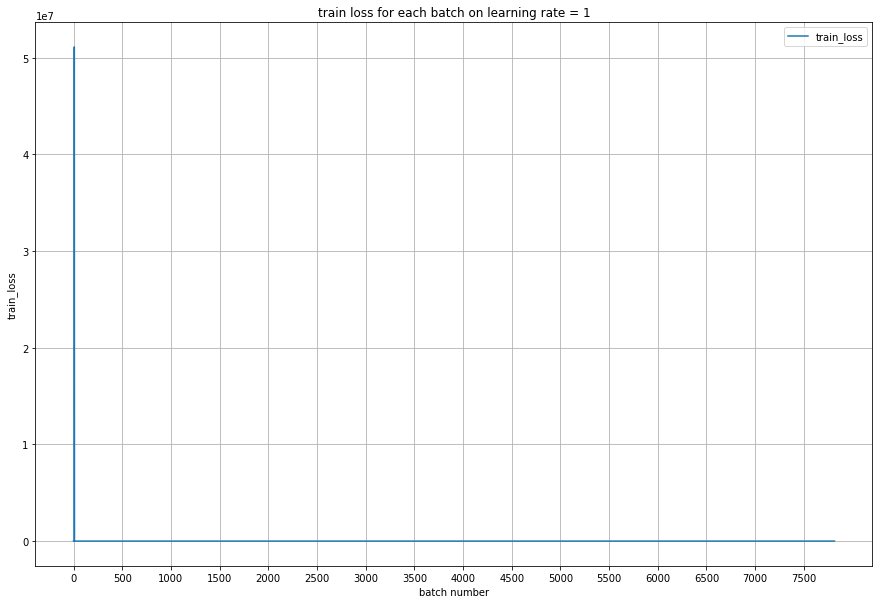


 ------------------------ learning_rate = 0.01 ---------------------------- 

Checkpoint saved
Epoch 0, Train Accuracy: 0.52984 , Test Accuracy: 0.6325
Checkpoint saved
Epoch 1, Train Accuracy: 0.67526 , Test Accuracy: 0.6645
Checkpoint saved
Epoch 2, Train Accuracy: 0.74106 , Test Accuracy: 0.681
Checkpoint saved
Epoch 3, Train Accuracy: 0.793 , Test Accuracy: 0.6861
Epoch 4, Train Accuracy: 0.8419 , Test Accuracy: 0.6844
train model time : 130.63784551620483 sec


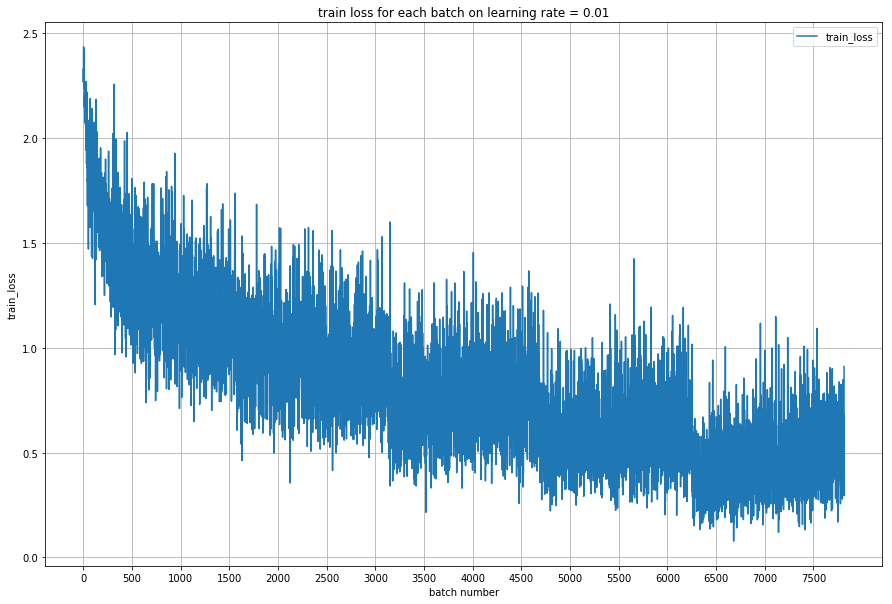


 ------------------------ learning_rate = 0.0001 ---------------------------- 

Checkpoint saved
Epoch 0, Train Accuracy: 0.27132 , Test Accuracy: 0.3527
Checkpoint saved
Epoch 1, Train Accuracy: 0.36988 , Test Accuracy: 0.3999
Checkpoint saved
Epoch 2, Train Accuracy: 0.4147 , Test Accuracy: 0.431
Checkpoint saved
Epoch 3, Train Accuracy: 0.44618 , Test Accuracy: 0.4658
Checkpoint saved
Epoch 4, Train Accuracy: 0.46868 , Test Accuracy: 0.4814
train model time : 130.167160987854 sec


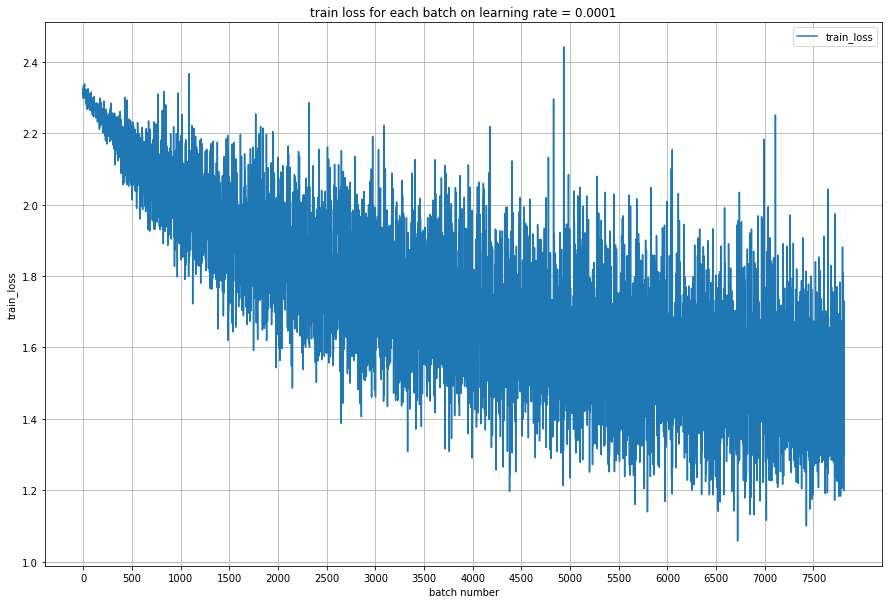

In [0]:
data_folder_addr = "./p4/data"
result_folder_addr = "./p4"
batch_size = 32
epoch = 5

class TestNet(nn.Module):
    def __init__(self,num_classes=10):
        super(TestNet,self).__init__()

        self.convLayer1 = ConvLayer(in_channels=3,out_channels=32, init_func = weights_init_normal , active_func = "ReLU")
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.convLayer2 = ConvLayer(in_channels=32,out_channels=128, init_func = weights_init_normal , active_func = "ReLU")
        
        self.net = nn.Sequential(self.convLayer1, self.pool1, self.convLayer2)

        self.fc = nn.Linear(in_features=16*16*128, out_features=num_classes)
        self.fc.apply(weights_init_normal)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,16*16*128)
        output = self.fc(output)
        return output

train_transformations = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = None
train_loader = load_data(data_folder_addr, True, train_transformations, batch_size, "OFF")

test_transformations = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

test_loader = None
test_loader = load_data(data_folder_addr, False, test_transformations, batch_size, "OFF")

learning_rate_list = [1, 0.01, 0.0001]

for learning_rate in learning_rate_list:
  
  print("\n ------------------------ learning_rate = {} ---------------------------- \n".format(learning_rate))
  
  model = None 
  model = TestNet(num_classes=10)
  
  optimizer = None 
  optimizer = SGD(model.parameters(), lr=learning_rate, momentum = 0.9)
  loss_fn = None 
  loss_fn = nn.CrossEntropyLoss()
   
  train_acc = None 
  train_loss_list = None
  test_acc = None
  train_acc, train_loss_list, test_acc = train_model(model, optimizer, loss_fn, epoch, train_loader, test_loader, result_folder_addr)
  
  plt.figure(figsize=(15,10))
  
  plt.plot(range(len(train_loss_list)), train_loss_list, label = "train_loss") 

  plt.xlabel('batch number') 
  plt.ylabel('train_loss')
  plt.title('train loss for each batch on learning rate = {}'.format(learning_rate)) 
  
  plt.xticks(np.arange(min(range(len(train_loss_list))), max(range(len(train_loss_list)))+1, 500))
  
  plt.legend() 
  plt.grid()

  plt.show() 

<div style="ltr">
  <h3 align="left"> Part 4 conclusion :</h3>
 </div>

<div style="ltr">
  <h2 align="left">  Part 5 : influence of batch size and it relation to learning rate </h2>
 </div>

In [0]:
data_folder_addr = "./p5/data"
result_folder_addr = "./p5"
epoch = 5

class TestNet(nn.Module):
    def __init__(self,num_classes=10):
        super(TestNet,self).__init__()

        self.convLayer1 = ConvLayer(in_channels=3,out_channels=32, init_func = weights_init_normal , active_func = "ReLU")
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.convLayer2 = ConvLayer(in_channels=32,out_channels=128, init_func = weights_init_normal , active_func = "ReLU")
        
        self.net = nn.Sequential(self.convLayer1, self.pool1, self.convLayer2)

        self.fc = nn.Linear(in_features=16*16*128, out_features=num_classes)
        self.fc.apply(weights_init_normal)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,16*16*128)
        output = self.fc(output)
        return output

batch_size_list = [32, 64, 256]
learning_rate_list = [100, 0.01, 0.0001]
train_loss_list = []

for batch_size in batch_size_list:
  train_transformations = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  train_loader = load_data(data_folder_addr, True, train_transformations, batch_size, "OFF")

  test_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

  test_loader = load_data(data_folder_addr, False, test_transformations, batch_size, "OFF")
  
  for learning_rate in learning_rate_list:
    print("------------------------ learning_rate = {} ----------------------------".format(learning_rate))
    
    model = TestNet(num_classes=10)
    
    optimizer = SGD(model.parameters(), lr=learning_rate, momentum = 0.9)
    loss_fn = nn.CrossEntropyLoss()

    train_acc, train_loss, test_acc = train_model(model, optimizer, loss_fn, epoch, train_loader, test_loader, result_folder_addr)

    train_loss_list.append(train_loss)
    
  plt.plot(learning_rate_list, train_loss_list, label = "train_loss") 
  
  plt.xlabel('learning_rate') 
  plt.ylabel('train_loss')
  plt.title('influence of learning rate on loss function value with batch size = {} '.format(batch_size)) 

  plt.legend() 
  plt.grid()

  plt.show() 

<div style="ltr">
  <h3 align="left"> Part 5 conclusion :</h3>
 </div>

<div style="ltr">
  <h2 align="left">  Part 6 : influence of activation function </h2>
 </div>

In [0]:
data_folder_addr = "./p6/data"
result_folder_addr = "./p6"
batch_size = 32
epoch = 5

class TestNet(nn.Module):
    def __init__(self,num_classes=10):
        super(TestNet,self).__init__()

        self.convLayer1 = ConvLayer(in_channels=3,out_channels=32, init_func = weights_init_uniform)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.convLayer2 = ConvLayer(in_channels=32, out_channels=128, init_func = weights_init_uniform)

        #Add all the convLayers into the Sequential layer in exact order
        self.net = nn.Sequential(self.convLayer1, self.pool1, self.convLayer2)

        self.fc = nn.Linear(in_features=16*16*128,out_features=num_classes)
        self.fc.apply(weights_init_uniform)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,16*16*128)
        output = self.fc(output)
        return output

active_func_list = ["ReLU", "Tanh", "LeakyReLU‬", "Softplus"]

train_transformations = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = load_data(data_folder_addr, True, train_transformations, batch_size, "OFF")

test_transformations = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

test_loader = load_data(data_folder_addr, False, test_transformations, batch_size, "OFF")

for active_func in active_func_list:
  
  print("/n ================================ active_func = {} ================================ /n".format(active_func))
  
  model = TestNet(num_classes=10, active_func=active_func)

  optimizer = SGD(model.parameters(), lr=0.01, momentum = 0.9)
  loss_fn = nn.CrossEntropyLoss()

  train_model(model, optimizer, loss_fn, epoch, train_loader, test_loader, result_folder_addr)

<div style="ltr">
  <h3 align="left"> Part 6 conclusion :</h3>
 </div>

<div style="ltr">
  <h2 align="left">  Part 7 : influence of ‫‪momentum‬‬</h2>
 </div>

In [0]:
data_folder_addr = "./p7/data"
result_folder_addr = "./p7"
batch_size = 32
epoch = 5

class TestNet(nn.Module):
    def __init__(self,num_classes=10):
        super(TestNet,self).__init__()

        self.convLayer1 = ConvLayer(in_channels=3,out_channels=32, init_func = weights_init_uniform)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.convLayer2 = ConvLayer(in_channels=32, out_channels=128, init_func = weights_init_uniform)

        #Add all the convLayers into the Sequential layer in exact order
        self.net = nn.Sequential(self.convLayer1, self.pool1, self.convLayer2)

        self.fc = nn.Linear(in_features=16*16*128,out_features=num_classes)
        self.fc.apply(weights_init_uniform)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,16*16*128)
        output = self.fc(output)
        return output

train_transformations = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = load_data(data_folder_addr, True, train_transformations, batch_size, "OFF")

test_transformations = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

test_loader = load_data(data_folder_addr, False, test_transformations, batch_size, "OFF")


print("/n ================================ with momentum ================================ /n")

model = TestNet(num_classes=10, active_func=active_func)

optimizer = SGD(model.parameters(), lr=0.01, momentum = 0.9)
loss_fn = nn.CrossEntropyLoss()

train_model(model, optimizer, loss_fn, epoch, train_loader, test_loader, result_folder_addr)

print("/n =============================== without momentum =============================== /n")

model = TestNet(num_classes=10, active_func=active_func)

optimizer = SGD(model.parameters(), lr=0.01, momentum = 0.9)
loss_fn = nn.CrossEntropyLoss()

train_model(model, optimizer, loss_fn, epoch, train_loader, test_loader, result_folder_addr)


<div style="ltr">
  <h3 align="left"> Part 7 conclusion :</h3>
 </div>